In [408]:
df = pd.read_csv("/tmp/temp.csv")

In [409]:
diff = df[['mid', 'balance']].diff(axis=0)

In [410]:
diff['mid'] = df['mid'].pct_change().dropna()
dd = diff.iloc[:-10].cumsum(axis=0)

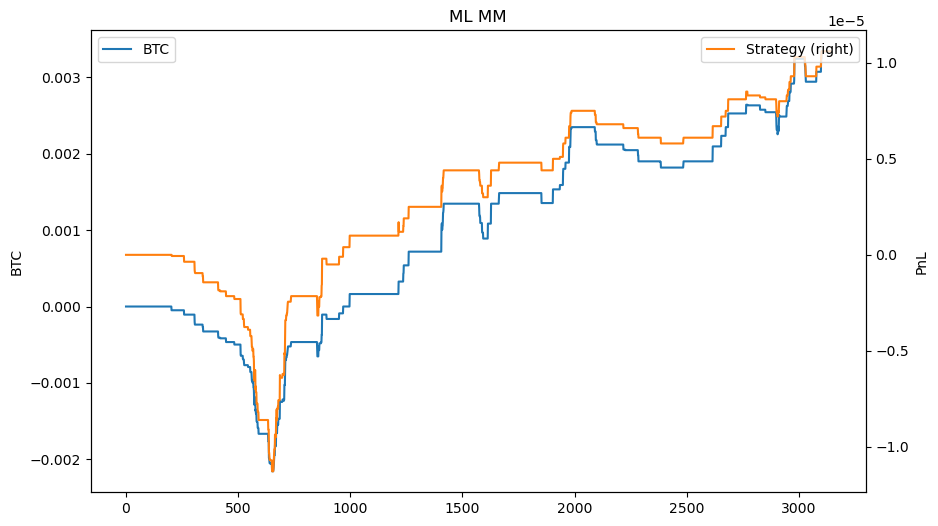

In [411]:
import matplotlib.pyplot as plt

ax = dd['mid'].plot(label='BTC', figsize=(10, 6))
dd['balance'].plot(secondary_y=True, label='Strategy', ax=ax)

ax.set_ylabel('BTC')
ax.right_ax.set_ylabel('PnL')
plt.title('ML MM')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')
plt.show()

<Axes: >

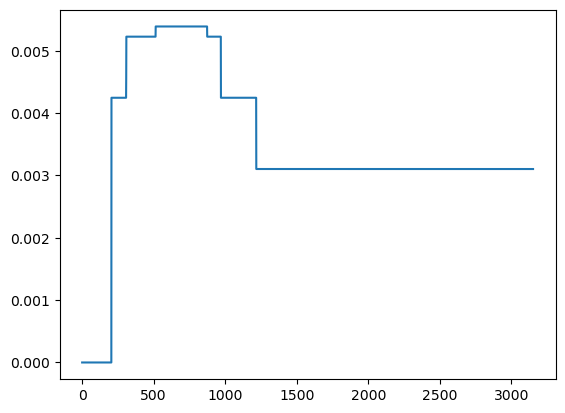

In [397]:
df['leverage'].plot()

In [398]:
0.005 * 65000

325.0

In [384]:
90 / 15

6.0